<a href="https://colab.research.google.com/github/calistasalscpw/Selena-Finance-Tracker/blob/main/Selena_Shopee_rev_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone Project - Selena (Shopee)

**Proses Analisis oleh Model ML (Menggunakan File .pkl)**

- **Backend kemudian memuat model ML yang sudah dilatih (disimpan dalam format .pkl) menggunakan library Pickle di Python.**
- Model ML ini memproses data transaksi pengguna yang sudah diambil dari database untuk melakukan beberapa tugas analisis:
    - Arus Kas: Mengidentifikasi pola pemasukan dan pengeluaran.
    - Saran Keuangan: Berdasarkan analisis tren keuangan pengguna, model bisa memberikan saran, misalnya mengurangi pengeluaran di kategori tertentu.
    - Deteksi Anomali Pengeluaran: Model ML mendeteksi adanya transaksi atau pengeluaran yang tidak biasa atau mencurigakan.

Pengembalian Hasil Analisis ke Backend (ML ke CC)

- Model ML menghasilkan output analisis, seperti rekomendasi keuangan atau deteksi anomali, yang dikonversi ke **format JSON**.
- Backend menerima hasil ini dan menggabungkannya menjadi satu respons JSON yang siap dikirim ke aplikasi mobile.

## Import Libraries

In [211]:
import pickle
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import ticker
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

## Preprocessing Data

In [212]:
#FUNGSI UNTUK PREPROCESSING DATA

def preprocess_data(file_path):
  # Membaca file dataset
  data = pd.read_json(file_path)

  # Menghitung total_income dan total_expense
  data['total_income'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Income' else 0, axis=1)
  data['total_expense'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Expense' else 0, axis=1)

  # Menghitung net_cashflow
  data['net_cashflow'] = data['total_income'] - data['total_expense']

  # Mengelompokkan berdasarkan bulan
  data['month'] = pd.to_datetime(data['date']).dt.to_period('M')

  # Menghitung total per bulan
  summary = data.groupby('month').agg(
    total_income = ('total_income', 'sum'),
    total_expense = ('total_expense', 'sum'),
    net_cashflow = ('net_cashflow', 'sum')
  ).reset_index()

  #Period ke timestamp
  summary['month'] = summary['month'].dt.to_timestamp()

  return summary

## Cashflow Analysis

Analisis cashflow berdasarkan total pemasukan dan pengeluaran

In [213]:
DATA_PATH = './data/merger_dataset.json'

data_summary = preprocess_data(DATA_PATH)
print(data_summary)

        month  total_income  total_expense  net_cashflow
0  2023-08-01       1390000        1412950        -22950
1  2023-09-01       1607000        1443530        163470
2  2023-10-01       1510000        1652785       -142785
3  2023-11-01       1200000        1077068        122932
4  2023-12-01       1750000        1829508        -79508
5  2024-01-01       9735000       11400361      -1665361
6  2024-02-01      19201015       18971500        229515
7  2024-03-01       3620000        2670818        949182
8  2024-04-01       6250101        4098822       2151279
9  2024-05-01       4527000        6434944      -1907944
10 2024-06-01       3810000        4157915       -347915
11 2024-07-01      11720000       11100621        619379
12 2024-08-01       9629000        9142500        486500
13 2024-09-01       2000000        3438231      -1438231
14 2024-10-01      13382000       11673752       1708248
15 2024-11-01       9521142        8280550       1240592


In [214]:
#Min-Max Scaler Initialization
income_scaler = MinMaxScaler(feature_range=(0, 1))
expense_scaler = MinMaxScaler(feature_range=(0, 1))
cashflow_scaler = MinMaxScaler(feature_range=(0, 1))

## Defining Functions
---



Terdiri atas beberapa fungsi:
- Fungsi `plot_series`: Berisi matplotlib untuk visualisasi data berupa time series
- Fungsi `train_val_split`: Digunakan untuk membagi time series menjadi data latih dan data validasi
- Fungsi `create_windowed_dataset`: Digunakan untuk membuat dataset berbentuk windowed

In [215]:
def time_series(data):
  # Rescaling dengan MinMaxScaler
  total_income = income_scaler.fit_transform(data[['total_income']])
  total_expense = expense_scaler.fit_transform(data[['total_expense']])
  net_cashflow = cashflow_scaler.fit_transform(data[['net_cashflow']])

  # Assign value variabel time dan series
  time = data['month'].tolist()
  income = total_income.flatten()
  expense = total_expense.flatten()
  net_cashflow = net_cashflow.flatten()

  return time, income, expense, net_cashflow

In [216]:
TIME, INCOME, EXPENSE, NET_CASHFLOW = time_series(data_summary)

INCOME_SCALED = income_scaler.inverse_transform(np.array(INCOME).reshape(-1,1)).flatten()
EXPENSE_SCALED = expense_scaler.inverse_transform(np.array(EXPENSE).reshape(-1,1)).flatten()
NET_CASHFLOW_SCALED = cashflow_scaler.inverse_transform(np.array(NET_CASHFLOW).reshape(-1,1)).flatten()

In [217]:
#Visualisasi Data

def plot_value(time, value, label):
  plt.plot(time, value, label = label)
  formatter = ticker.ScalarFormatter()
  formatter.set_scientific(False)
  plt.xlabel("Bulan Transaksi")
  plt.ylabel("Jumlah Uang")
  plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
  plt.gca().yaxis.set_major_formatter(formatter)
  plt.legend()
  plt.gcf().autofmt_xdate()
  plt.show()

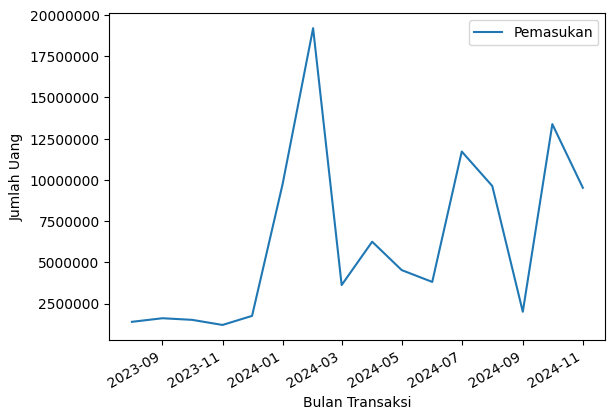

In [218]:
plot_value(TIME, INCOME_SCALED, "Pemasukan")

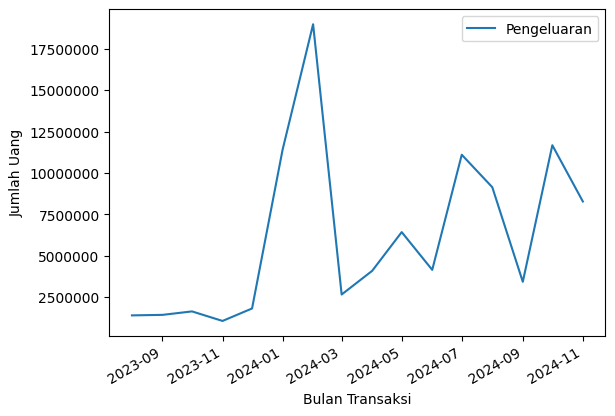

In [219]:
plot_value(TIME, EXPENSE_SCALED, "Pengeluaran")

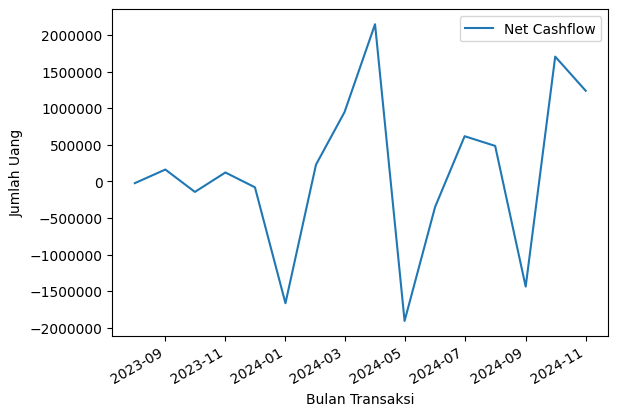

In [220]:
plot_value(TIME, NET_CASHFLOW_SCALED, "Net Cashflow")

In [221]:
# Format data JSON
data_for_export = {
  "cashflow_analysis": [
    {
      "time": TIME[i].strftime('%Y-%m'),
      "total_income": INCOME[i],
      "total_expense": EXPENSE[i],
      "net_cashflow": NET_CASHFLOW[i]
    }
    for i in range(len(TIME))
  ]
}

# Simpan ke JSON
with open('clean_data.json', 'w') as json_file:
    json.dump(data_for_export, json_file, indent=1)

# Anomaly Detection

In [222]:
# Scaler expense untuk deteksi anomali
scaler = MinMaxScaler(feature_range=(0, 1))

In [223]:
def preprocess_expense(file_path):
    data = pd.read_json(file_path)

    # Mengelompokkan berdasarkan bulan
    data['time'] = pd.to_datetime(data['date']).dt.to_period('M')

    expense = scaler.fit_transform(data[['expense']])    

    # Assign value variable time and series
    time = data['time'].tolist()
    expense = expense.flatten()

    return time, expense

In [224]:
DATA_EXPENSE = './data/expense_data.json'

#Preprocessing data untuk deteksi anomali
TIME, SERIES = preprocess_expense(DATA_EXPENSE)
SERIES_SCALED = scaler.inverse_transform(np.array(SERIES).reshape(-1, 1)).flatten()

# Global Variabel Model
split_ratio = 0.8
SPLIT_TIME = int(len(SERIES) * split_ratio)
WINDOW_SIZE = 32
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

In [225]:
def train_val_split(time, series):
    """Split time series into train and validation sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [226]:
def create_windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    """
    Membuat dataset dalam bentuk windowed untuk time series.

    Parameters:
    - series: Data time series dalam bentuk array atau list.
    - window_size: Jumlah langkah dalam satu jendela input.
    - batch_size: Jumlah data yang diproses dalam satu batch.
    - shuffle_buffer: Ukuran buffer untuk pengacakan data.

    Returns:
    - dataset: Dataset dengan pasangan input-output berdasarkan window size.
    """

    # Konversi data series ke dalam dataset tensorflow
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Membuat window untuk setiap sample
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Konversi setiap window ke dalam bentuk batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Memisahkan window menjadi input (features) dan output (label)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Mengacak data menggunakan shuffle buffer
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Membuat batch data
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [227]:
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2),
        tf.keras.layers.LSTM(32, dropout=0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [228]:
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """

    model = create_uncompiled_model()

    model.compile(loss = tf.keras.losses.Huber(),
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics=["mae"])

    return model

## Plot Series

In [229]:
def plot_series_with_anomalies(time, true_series, forecast, threshold_factor=2):
    #Menghitung eror absolute dan threshold untuk anomali
    error = np.abs(true_series - forecast)
    threshold = threshold_factor * np.mean(error)

    #Identifikasi anomali
    anomalies = error > threshold
    anomaly_time = np.array(time)[anomalies]
    anomaly_values = np.array(true_series)[anomalies]

    #Plot time series dan forecast
    plt.figure(figsize=(16, 8))
    plt.plot(time, true_series, label='True Series', color='blue')
    plt.plot(time, forecast, label = 'forecast', color='orange', linestyle='--')

    #Highlight anomali
    plt.scatter(anomaly_time, anomaly_values, color='red', label='Anomali Pengeluaran', zorder=5)

    plt.xlabel("Waktu")
    plt.ylabel("Pengeluaran")
    plt.title("Forecast dengan Anomali")
    plt.legend()
    plt.grid(True)
    plt.show()

In [161]:
#plot_series(TIME, EXPENSE)

In [230]:
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)
series_train_windowed = create_windowed_dataset(series_train)
series_valid_windowed = create_windowed_dataset(series_valid)

# model
uncompiled_model = create_uncompiled_model()

In [231]:
example_batch = series_train_windowed.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (32, 1)


c:\Program Files\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [232]:
model = create_model()

In [233]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

history = model.fit(series_train_windowed, validation_data=series_valid_windowed, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0024 - mae: 0.0240 - val_loss: 0.0031 - val_mae: 0.0349 - learning_rate: 1.0000e-08
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0029 - mae: 0.0274 - val_loss: 0.0031 - val_mae: 0.0349 - learning_rate: 1.1220e-08
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0048 - mae: 0.0304 - val_loss: 0.0031 - val_mae: 0.0349 - learning_rate: 1.2589e-08
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035 - mae: 0.0283 - val_loss: 0.0031 - val_mae: 0.0349 - learning_rate: 1.4125e-08
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0057 - mae: 0.0302 - val_loss: 0.0031 - val_mae: 0.0349 - learning_rate: 1.5849e-08
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0041 - mae: 0.0299 - val_loss: 0.0031 - val_mae: 0.0348 - learning_rate: 1.7783e-08
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0034 - mae: 0.0292 - val_loss: 0.0031 - val_mae: 0.0348 - lear

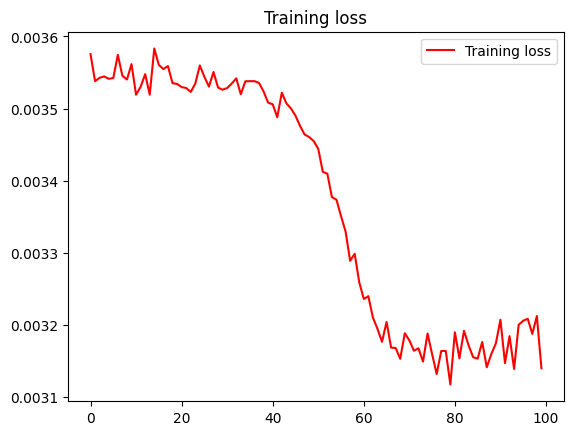

In [234]:
# Plot the training loss for each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

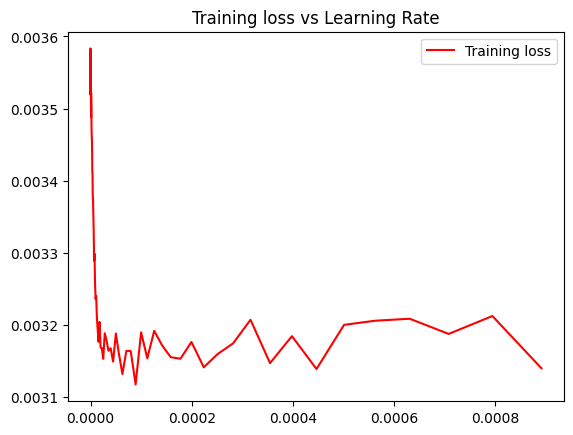

In [235]:
# Plot the training loss for each learning rate

lr = history.history['learning_rate']

plt.plot(lr, loss, 'r', label='Training loss')
plt.title('Training loss vs Learning Rate')
plt.legend(loc=0)
plt.show()

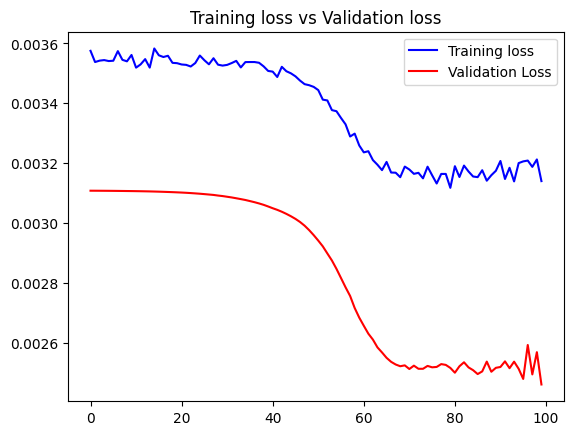

In [236]:
# Plot the training loss for each learning rate

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training loss vs Validation loss')
plt.legend()
plt.show()

## Evaluate Forecast

Using MAE and MSE as metrics to evaluate forecast (prediction)

In [237]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

More efficient way to forecast

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [238]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [239]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

      1/Unknown 0s 482ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F2112BE980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


TypeError: float() argument must be a string or a real number, not 'Period'

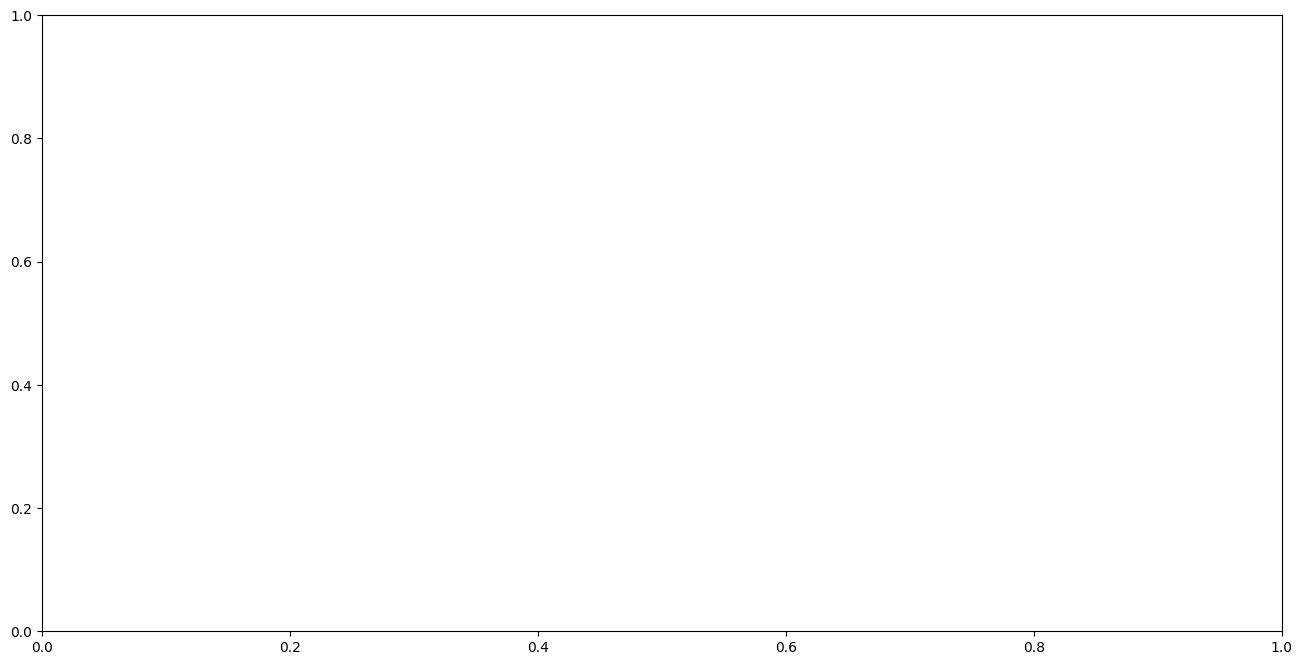

In [240]:
plot_series_with_anomalies(time_valid, series_valid, rnn_forecast, threshold_factor=2)

TypeError: float() argument must be a string or a real number, not 'Period'

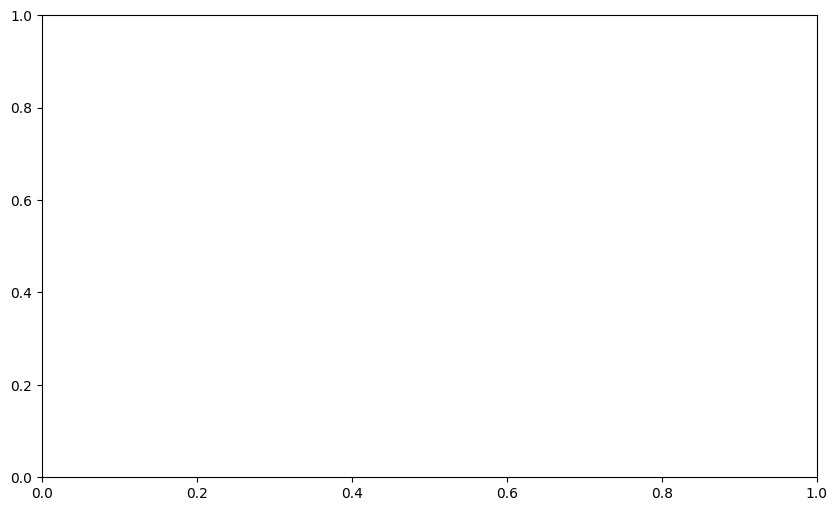

In [208]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_value(time_valid, series_valid, "Series")
plot_value(time_valid, rnn_forecast, "Forecast")

In [209]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.00, mae: 0.03 for forecast


Saving metrics

In [210]:
# Save metrics into a dictionary
metrics_dict = {
    "mse": float(mse),
    "mae": float(mae)
}

# Save your metrics in a binary file 
with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)